<a href="https://colab.research.google.com/github/Seouyang/Today-I-Learned/blob/master/word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word2Vec

### 1. Implement Word2Vec (Skip-gram)


In [ ]:
from abc import ABC
from typing import List, Dict, Tuple, Set
import random
import torch.nn.functional as F
from random import randint
import re
from collections import Counter
import torch
from torch.utils.data import IterableDataset

In [ ]:
#make tokenizing
def tokenize(sentence):
  sentence = re.sub("[.]", " . ", sentence)
  sentence = re.sub("[,]", " , ", sentence)
  sentence = re.sub("[!]", " ! ", sentence)
  sentence = re.sub("[?]", " ? ", sentence)
  tokens = sentence.split()
  assert type(tokens) == list
  return tokens

In [ ]:
#build vocabulary
def build_vocab(sentences: List[List[str]], min_freq: int) -> Tuple[List[str], Dict[str, int], List[int]]:
  #special tokens
  PAD = '<PAD>'
  PAD_idx = 0
  UNK = '<UNK>'
  UNK_idx = 1

  word2idx = {PAD: PAD_idx, UNK: UNK_idx}
  idx2word = {PAD_idx: PAD, UNK_idx: UNK}

  flatten = lambda l: [item for sublist in l for item in sublist] #for sublist in l: for item in sublist: item
  word_freq = dict(Counter(flatten(sentences)))

  for word_item in word_freq.items():
    if word_item[0] not in word2idx:
      idx2word[len(word2idx)] = word_item[0]
      word2idx[word_item[0]] = len(word2idx)
  
  for word_item in word_freq.items():
    if word_item[1] < min_freq:
      del idx2word[word2idx[word_item[0]]]
      del word2idx[word_item[0]]
  
  for idx, word_item in enumerate(word2idx.items()):
    word2idx[word_item[0]] = idx
  
  word_freq = {PAD: 0, UNK: 0}
  for word_list in sentences:
    for word in word_list:
      if word not in word2idx:
        word_freq[UNK] += 1
      else:
        try:
          word_freq[word] += 1
        except KeyError:
          word_freq[word] = 1

  word_freq = list(word_freq.values())
  idx2word = list(idx2word.values())

  assert idx2word[PAD_idx] == PAD and word2idx[PAD] == PAD_idx, \
  "PAD token should be placed properly"
  assert idx2word[UNK_idx] == UNK and word2idx[UNK] == UNK_idx, \
  "UNK token should be placed properly"
  assert len(idx2word) == len(word2idx) and len(idx2word) == len(word_freq), \
  "Size of idx2word, word2idx and word_freq should be same"

  return idx2word, word2idx, word_freq

In [ ]:
#define skipgram
def skipgram(sentence, window_size, center_word_loc):
  outside_words = []
  
  for w in range(-window_size, window_size + 1):
    context_word_pos = center_word_loc + w
    if context_word_pos < 0 or context_word_pos >= len(sentence) or center_word_loc == context_word_pos:
      continue
    outside_words.append(sentence[context_word_pos])
  
  assert type(sentence[center_word_loc]) == str and type(outside_words) == list
  return sentence[center_word_loc], outside_words

In [ ]:
#implement Word2vec
class Word2Vec(torch.nn.Module, ABC):
  def __init__(self, n_tokens, word_dimension):
    super().__init__()
    self.center_vectors = torch.nn.Parameter(torch.empty([n_tokens, word_dimension]))
    self.outside_vectors = torch.nn.Parameter(torch.empty([n_tokens, word_dimension]))
    self.init_weights()
  
  def init_weights(self):
    torch.nn.init.normal_(self.center_vectors.data)
    torch.nn.init.normal_(self.outside_vectors.data)
  
  def forward(self, center_word_index: torch.Tensor, outside_word_indices: torch.Tensor):
    return naive_softmax_loss(self.center_vectors, self.outside_vectors, center_word_index, outside_word_indices)

class SkipgramDataset(IterableDataset):
  PAD_TOKEN = '<PAD>'
  PAD_TOKEN_IDX = 0
  UNK_TOKEN = '<UNK>'
  UNK_TOKEN_IDX = 1

  def __init__(self, path, window_size, min_freq, device=torch.device('cpu')):
    self._window_size = window_size

    with open(path, "r") as f:
      sentences = [tokenize(line.strip().lower()) for line in f]
    
    idx2word, word2idx, word_freq = build_vocab(sentences, min_freq=min_freq)

    self._sentences = sentences
    self._idx2word = idx2word
    self._word2idx = word2idx
    self._neg_sample_prob = torch.Tensor(word_freq).to(device) ** .75

  def n_tokens(self):
    return len(self._idx2word)
  
  def negative_sampler(self, outside_word_indices, K):
    indices = outside_word_indices.flatten()

    if outside_word_indices.device == torch.device('cpu'):
      negatives = []
      for index in indices:
        temp = self._neg_sample_prob[index].clone()
        self._neg_sample_prob[index] = 0.
        negatives.append(torch.multinomial(self._neg_sample_prob, num_samples=K, replacement=True))
        self._neg_sample_prob[index] = temp
      negatives = torch.stack(negatives)
    
    else:
      probs = self._neg_sample_prob.repeat(indices.shape[0], 1)
      probs.scatter_(dim=-1, index=indices.unsqueeze(-1), src=outside_word_indices.new_zeros([]))
      negatives = torch.distributions.categorical.Categorical(probs).sample([K]).T
    
    return negatives.reshape(list(outside_word_indices.shape) + [K]).detach()
  
  def idx2word(self, index: int) -> str:
    return self._idx2word[index]
  
  def word2idx(self, word: str) -> int:
    return self._word2idx[word]
  
  def __iter__(self):
    while True:
      index = randint(0, len(self._sentences) - 1)
      sentence = self._sentences[index]
      center_word, outside_words = skipgram(sentence, self._window_size, randint(0, len(sentence) - 1))

      center_word_index = self._word2idx.get(center_word, SkipgramDataset.UNK_TOKEN_IDX)
      outside_word_indices = list(
          map(lambda word: self._word2idx.get(word, SkipgramDataset.UNK_TOKEN_IDX), outside_words))
      outside_word_indices += [SkipgramDataset.PAD_TOKEN_IDX] * (self._window_size * 2 - len(outside_word_indices))

      yield center_word_index, torch.Tensor(outside_word_indices).to(torch.long)


In [ ]:
def naive_softmax_loss(center_vectors, outside_vectors, center_word_index, outside_word_indices):
  assert center_word_index.shape[0] == outside_word_indices.shape[0]
  n_tokens, word_dim = center_vectors.shape
  batch_size, outside_word_size = outside_word_indices.shape #outside word size = window size * 2
  PAD = 0

  batched_center_vectors = center_vectors[center_word_index]
  preds = torch.matmul(batched_center_vectors, torch.t(outside_vectors))
  preds[:, 0] = float('-inf') #pad token preprocessing

  log_preds = -F.log_softmax(preds, dim=1)
  batched_indices = torch.repeat_interleave(torch.arange(batch_size), outside_word_size)
  pad_mask = (outside_word_indices != 0)

  losses = log_preds[batched_indices, outside_word_indices.flatten()].view(batch_size, -1) * pad_mask
  losses[losses != losses] = 0
  losses = torch.sum(losses, 1)

  assert losses.shape == torch.Size([batch_size])
  return losses

In [ ]:
#implement Word2Vec with negative sampling
class NegSamplingWord2Vec(torch.nn.Module, ABC):
  def __init__(self, n_tokens: int, word_dimension: int, negative_sampler, K: int=10):
    super().__init__()
    self.center_vectors = torch.nn.Parameter(torch.empty([n_tokens, word_dimension]))
    self.outside_vectors = torch.nn.Parameter(torch.empty([n_tokens, word_dimension]))
    self.init_weights()
    self._negative_sampler = negative_sampler
    self._K = K

  def init_weights(self):
    torch.nn.init.normal_(self.center_vectors.data)
    torch.nn.init.normal_(self.outside_vectors.data)

  def forward(self, center_word_index: torch.Tensor, outside_word_indices: torch.Tensor):
    return neg_sampling_loss(self.center_vectors, self.outside_vectors, center_word_index, outside_word_indices, self._negative_sampler, self._K)

In [ ]:
def neg_sampling_loss(center_vectors, outside_vectors, center_word_index, outside_word_indices, negative_sampler, K: int=10):
  assert center_word_index.shape[0] == outside_word_indices.shape[0]
  n_tokens, word_dim = center_vectors.shape
  batch_size, outside_word_size = outside_word_indices.shape
  PAD = SkipgramDataset.PAD_TOKEN_IDX

  negative_samples: torch.Tensor = negative_sampler(outside_word_indices, K)
  assert negative_samples.shape == torch.Size([batch_size, outside_word_size, K])

  batch_center_vectors = center_vectors[center_word_index]
  batch_dot_product = torch.einsum('bj, kj -> bk', [batch_center_vectors, outside_vectors])

  batch_true_loss = torch.log(torch.sigmoid(torch.gather(batch_dot_product, 1, outside_word_indices)))

  batch_neg_dots = batch_dot_product.gather(1, negative_samples.reshape(batch_size, outside_word_size * K))
  batch_neg_dots = batch_neg_dots.view(batch_size, outside_word_size, K)
  batch_neg_loss = torch.sum(torch.log(torch.sigmoid(-batch_neg_dots)), dim=-1)

  loss_matrix = -(batch_true_loss + batch_neg_loss)
  losses = torch.sum(loss_matrix * (outside_word_indices != 0).int().float(), dim=-1)

  assert losses.shape == torch.Size([batch_size])
  return losses

### 2. Implement SentencePiece and Word2Vec

In [ ]:
!pip install sentencepiece
import nltk
nltk.download('movie_reviews')
!wget https://www.dropbox.com/s/8w9n3cim0b32k2y/train.txt
!wget https://www.dropbox.com/s/pwhn9gyjgvg39v5/pos_train.txt
!wget https://www.dropbox.com/s/7h8aa1xe270fnfy/neg_train.txt

     |████████████████████████████████| 1.2MB 5.8MB/s 
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
--2021-02-12 11:47:18--  https://www.dropbox.com/s/8w9n3cim0b32k2y/train.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.18, 2620:100:6032:18::a27d:5212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/8w9n3cim0b32k2y/train.txt [following]
--2021-02-12 11:47:18--  https://www.dropbox.com/s/raw/8w9n3cim0b32k2y/train.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9641c550703e317369b419b61e.dl.dropboxusercontent.com/cd/0/inline/BIxm3MIaHWfh52aodjuAI2n0IFRSlW5ikhi7PVhNFRKrW6kf8Elb_6-8lzqhGDv2TvRFkJob8SK0ZLIqpztKA3ixDm9ilE36MrOb7XMV4117Rm38pSXOe1PxQTxtpuiwMC0/file# [following]
--2021-02-12 11:47:19--  https://uc9641c550

In [ ]:
import os
import random
import numpy as np
from gensim.models import word2vec 
import nltk
from nltk.corpus import movie_reviews 
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
import matplotlib as mpl
import matplotlib.pyplot as plt
import sentencepiece as spm

In [ ]:
num_features = 300
negative = 10
min_word_count = 10
window = 5
downsampling = 0.75 #lower frequency for high-frequency words
epoch = 5

In [ ]:
sentences_for_SP = []
sentences_naive = []
pos_data = open("./pos_train.txt").readlines()
neg_data = open("./neg_train.txt").readlines()
data_ = pos_data + neg_data

In [ ]:
for line in data_:
  sentences_naive.append(line.strip().split(' '))

In [ ]:
%%time

spm.SentencePieceTrainer.train(input="./train.txt", model_prefix='m', vocab_size=10000, user_defined_symbols=['[CLS]', '[SEP]'])
sp = spm.SentencePieceProcessor(model_file='./m.model')

for line in data_:
  sentences_for_SP.append(sp.encode(line, out_type=str))

CPU times: user 11 s, sys: 189 ms, total: 11.2 s
Wall time: 8.57 s


In [ ]:
%%time

#skip-gram model training with naive splitted data
naive_model = word2vec.Word2Vec(sentences_naive,
                                sg = 1, #CBOW=0, skip-gram=1
                                negative=negative,
                                size=num_features,
                                min_count=min_word_count,
                                window=window,
                                sample=downsampling,
                                iter=epoch)
#skip-gram model training with sentencepiece data
model_with_SP = word2vec.Word2Vec(sentences_for_SP,
                                sg = 1, #CBOW=0, skip-gram=1
                                negative=negative,
                                size=num_features,
                                min_count=min_word_count,
                                window=window,
                                sample=downsampling,
                                iter=epoch)

CPU times: user 6min 6s, sys: 432 ms, total: 6min 7s
Wall time: 3min 7s


In [ ]:
#training results
naive_model.wv.most_similar("man")

[('woman', 0.7327990531921387),
 ('boy', 0.7250064015388489),
 ('girl', 0.7026304006576538),
 ('guy', 0.6864681243896484),
 ('teenager', 0.6811317205429077),
 ('doctor', 0.6747547388076782),
 ('person', 0.6709749102592468),
 ('lady', 0.6666989922523499),
 ('scientist', 0.6442269086837769),
 ('kid', 0.6430785655975342)]

In [ ]:
vector = naive_model["king"] - naive_model["man"] + naive_model["queen"]
print(naive_model.wv.similar_by_vector(vector, topn=10, restrict_vocab=None))

[('king', 0.727534294128418), ('queen', 0.6651617288589478), ('sir', 0.6215401291847229), ('oz', 0.582407534122467), ('creator', 0.5777720212936401), ('cheadle', 0.5763227939605713), ('sarandon', 0.5736681818962097), ('hamill', 0.5731076598167419), ('nathan', 0.5722091794013977), ('norman', 0.5721187591552734)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [ ]:
print(naive_model.wv.similarity(w1 = 'man', w2 = 'woman'))
print(naive_model.wv.similarity(w1 = 'uncle', w2 = 'aunt'))
print(naive_model.wv.similarity(w1 = 'king', w2 = 'queen'))

0.732799
0.793446
0.6630223


In [ ]:
#visualization
def render_TSNE(vocab, word_emb):
  tsne = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
  _tsne = tsne.fit_transform(word_emb)
  x_coordinate = _tsne[:, 0]
  y_coordinate = _tsne[:, 1]

  fig, ax = plt.subplots()
  fig.set_size_inches(40, 20)
  ax.scatter(x_coordinate, y_coordinate)

  for i, word in enumerate(random_vocab):
    ax.annotate(word, (x_coordinate[i], y_coordinate[i]), fontsize=30)
  
  plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


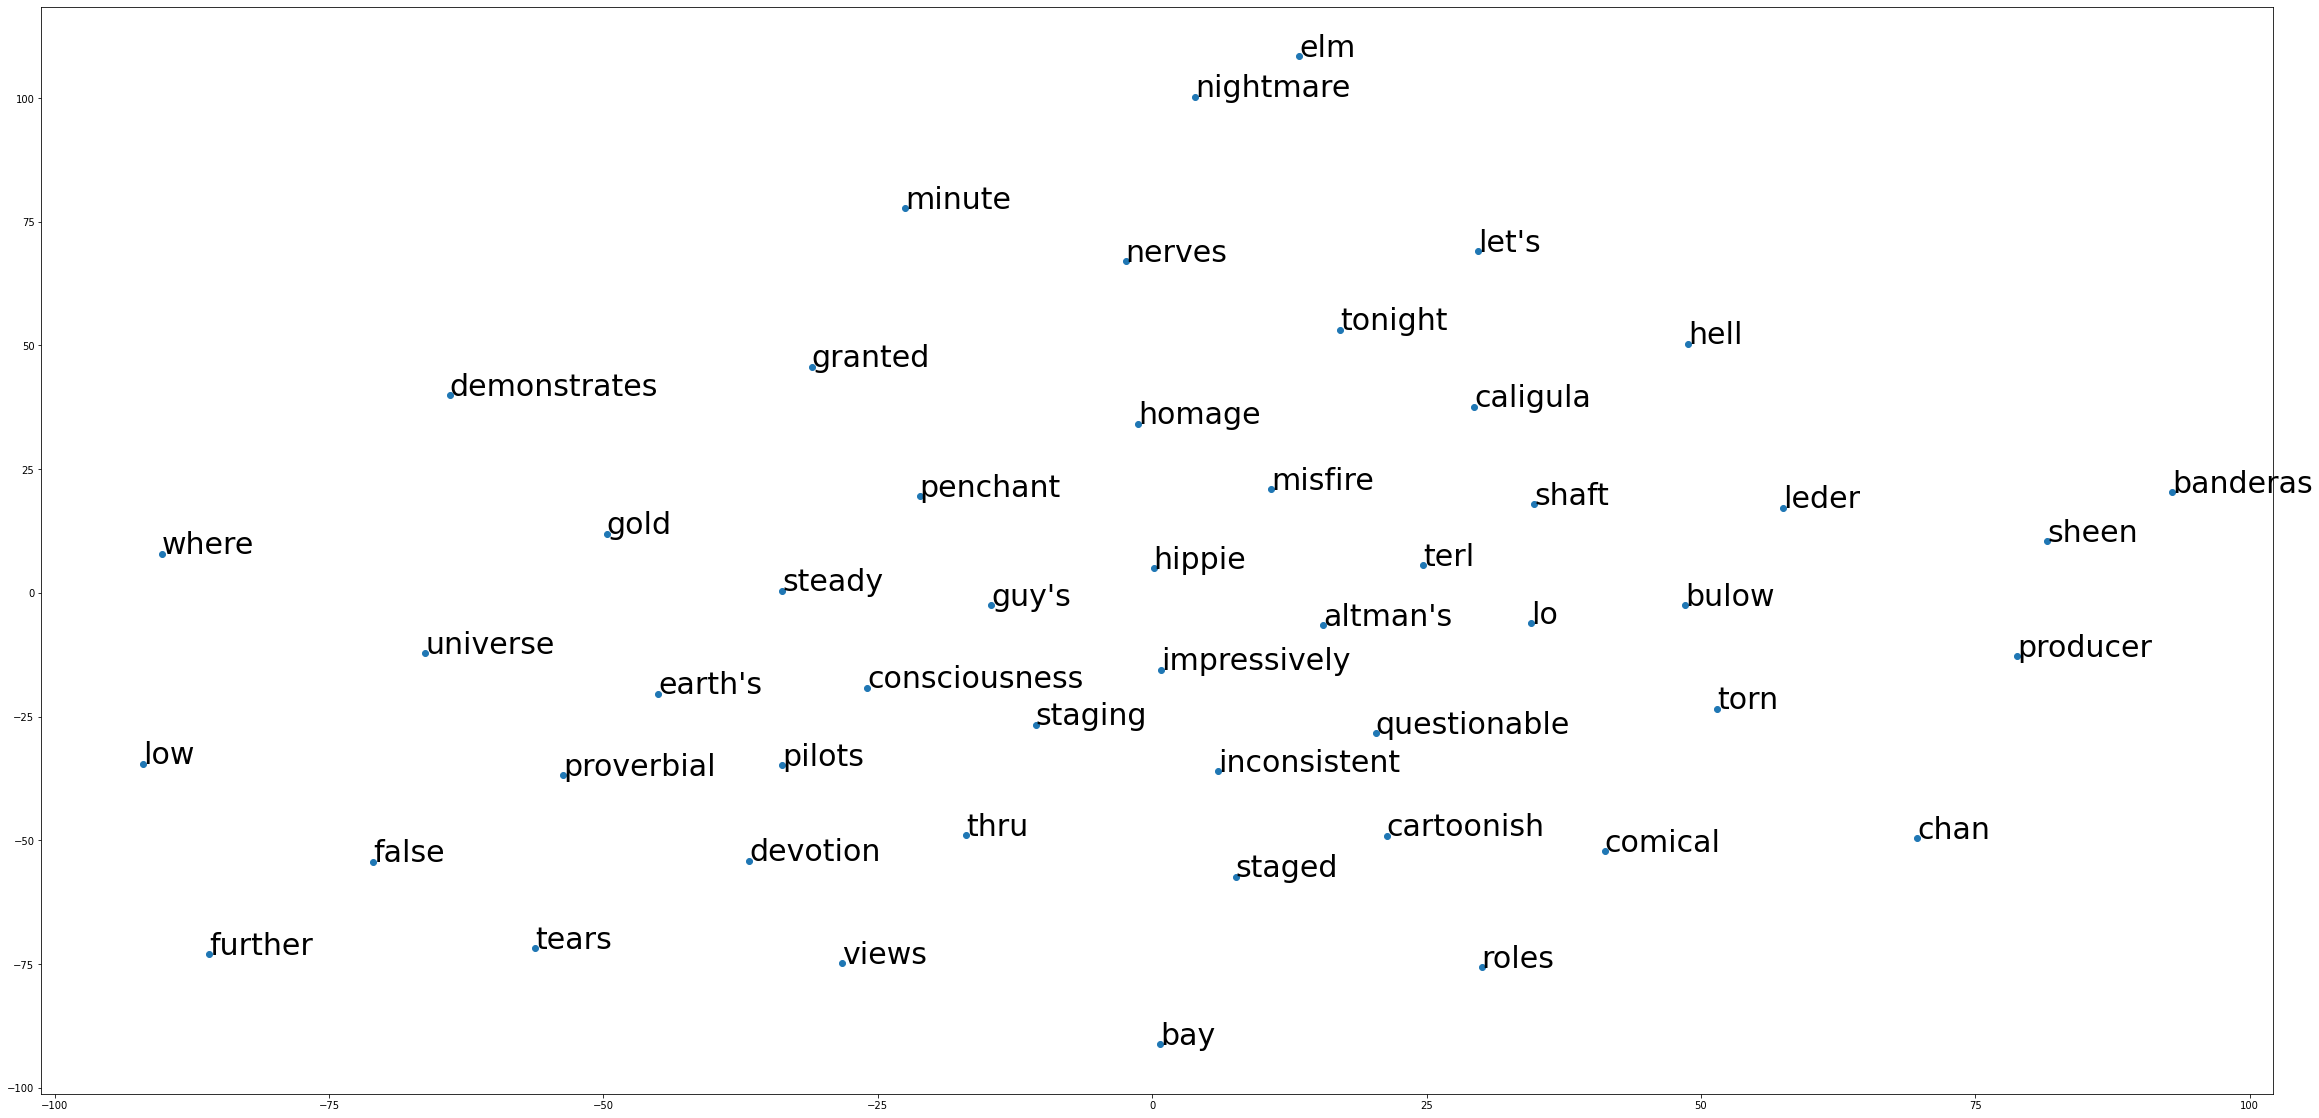

In [ ]:
vocab = list(naive_model.wv.vocab)
random_vocab = random.sample(vocab, k=50)
word_emb = naive_model[random_vocab]
render_TSNE(random_vocab, word_emb)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


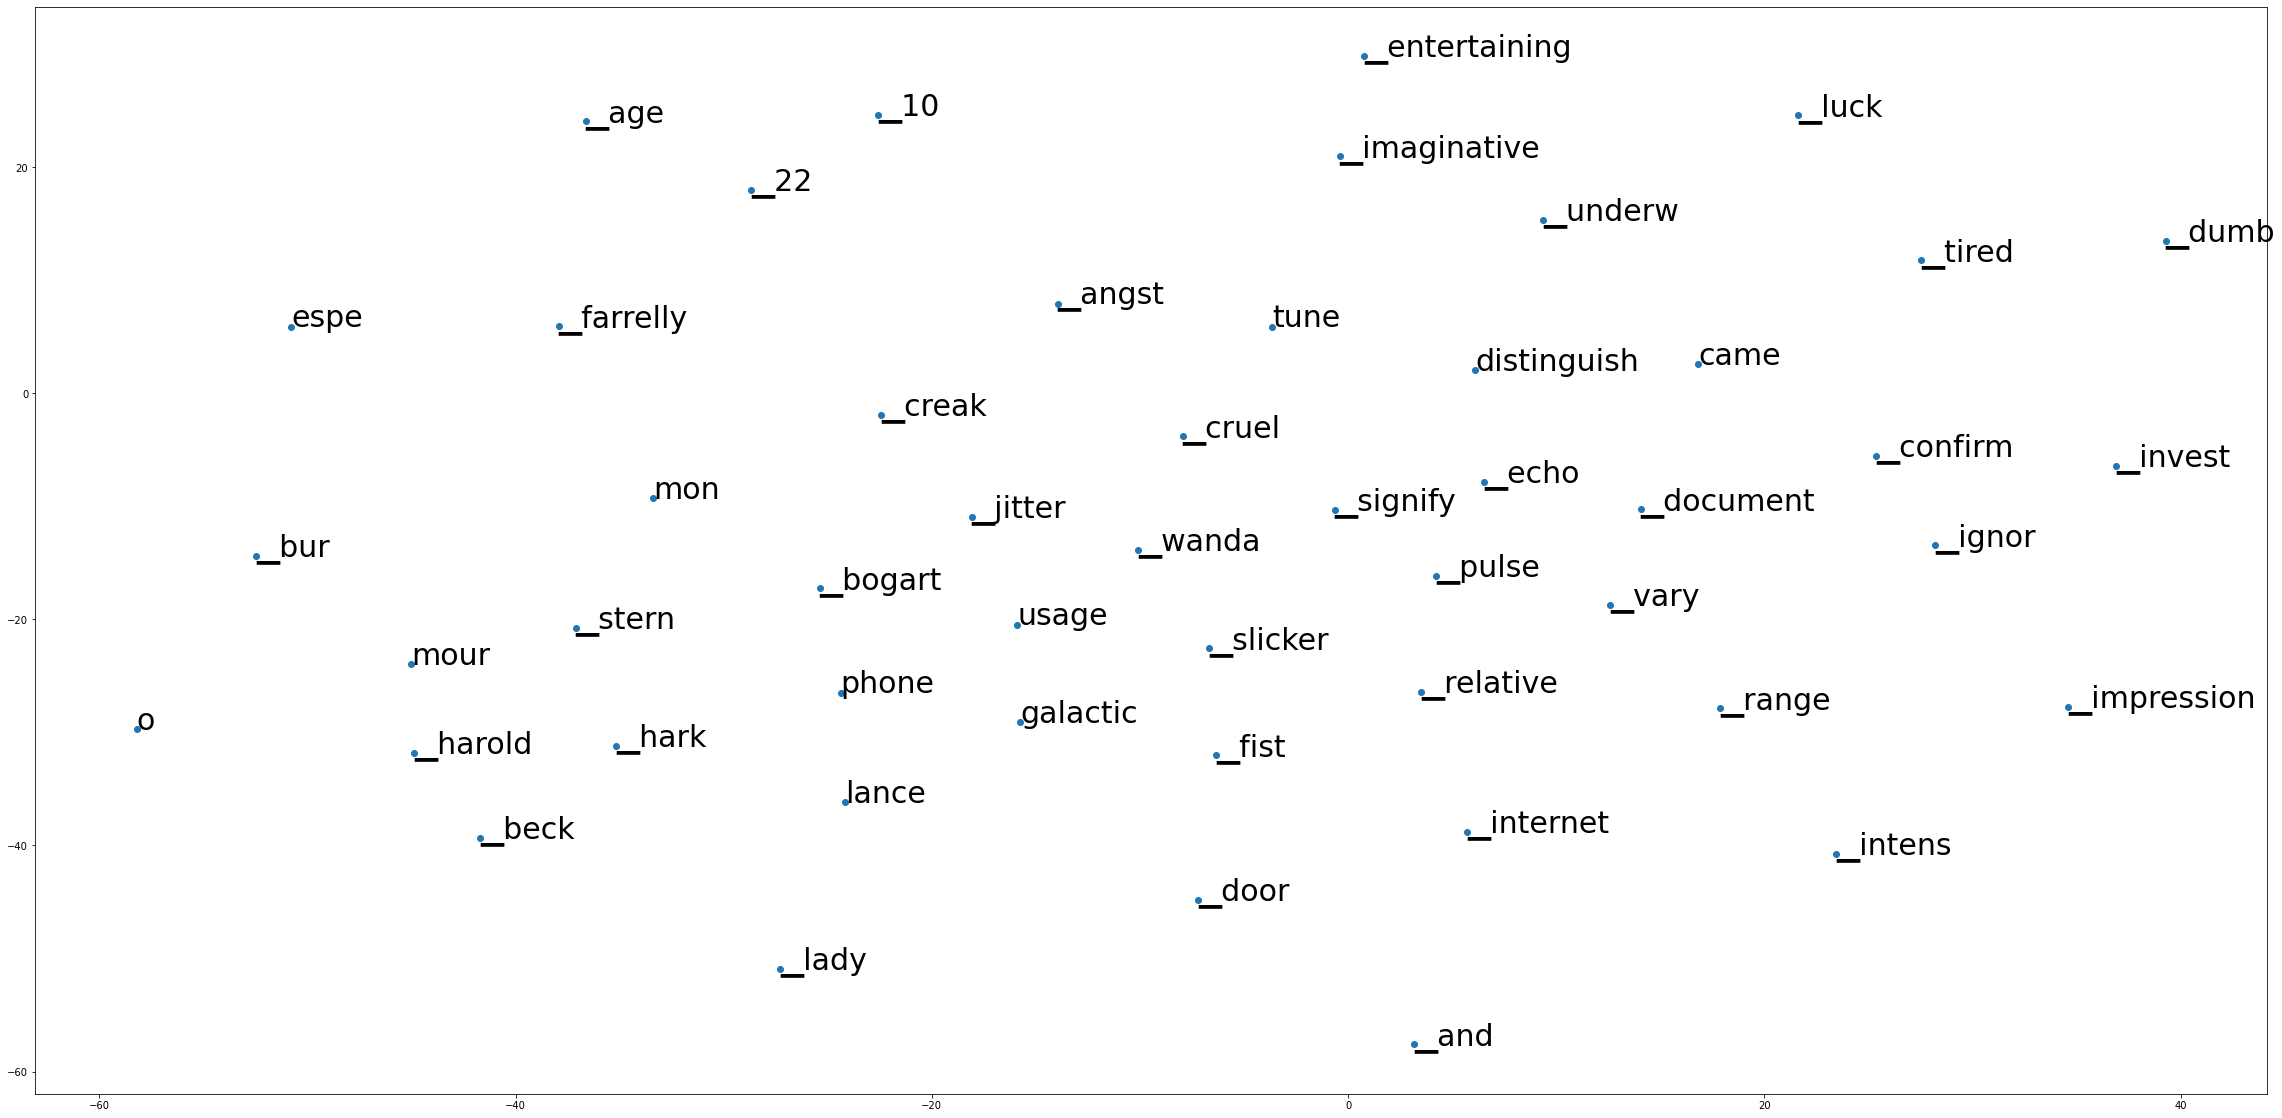

In [ ]:
vocab = list(model_with_SP.wv.vocab)
random_vocab = random.sample(vocab, k=50)
word_emb = model_with_SP[random_vocab]
render_TSNE(random_vocab, word_emb)